In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
import numpy as np
import requests
from scipy import stats
from talib import MACD, RSI, BBANDS
from datetime import datetime, timedelta, date
from IPython.display import display, HTML
%matplotlib inline
import json
import math
from dateutil import parser
from pytz import timezone
import sys

In [2]:
start_day_to_analyze = '2020-05-06'
end_day_to_analyze = '2020-05-07'

In [3]:
db_conn = create_engine("postgresql://momentum@localhost:5432/tradedb")

In [4]:
api = tradeapi.REST(base_url="https://api.alpaca.markets")
session = requests.session()

In [5]:
query = f'''
SELECT * 
FROM 
new_trades as t
WHERE 
    tstamp >= '{start_day_to_analyze}' and 
    tstamp < '{end_day_to_analyze}' 
ORDER BY symbol, tstamp
'''
trades =  pd.read_sql_query(query, db_conn)

In [6]:
query = f'''
SELECT * 
FROM 
algo_run as t
WHERE 
    start_time >= '{start_day_to_analyze}' and 
    start_time < '{end_day_to_analyze}' 
ORDER BY algo_run_id
'''
algo_runs = pd.read_sql_query(query, db_conn)

In [7]:
trades

,trade_id,algo_run_id,symbol,operation,qty,price,indicators,client_time,tstamp,stop_price,target_price
0,2838,516,AXTI,buy,345,5.48,"{'avg': 5.2278, 'rsi': 73.19884925123812, 'mac...",2020-05-06 13:50:06.808750+00:00,2020-05-06 13:50:06.898367,5.22,6.31
1,2840,516,AXTI,sell,345,5.51,"{'avg': 5.2922, 'rsi': [59.478391835000465, 63...",2020-05-06 14:38:30.536223+00:00,2020-05-06 14:38:30.806681,5.22,6.31
2,2837,516,RUBI,buy,326,6.83,"{'avg': 6.6804, 'rsi': 77.89076911251826, 'mac...",2020-05-06 13:49:50.141408+00:00,2020-05-06 13:49:50.321051,6.55,7.71
3,2839,516,RUBI,sell,326,6.66,"{'avg': 6.7057, 'rsi': [40.62038352642204, 39....",2020-05-06 14:04:09.619173+00:00,2020-05-06 14:04:09.809509,6.55,7.71
4,2841,516,STOR,buy,159,19.43,"{'avg': 19.0954, 'rsi': 77.8507592444134, 'mac...",2020-05-06 14:43:53.043512+00:00,2020-05-06 14:43:53.636854,18.91,21.09
5,2842,516,STOR,buy,1,19.43,"{'avg': 19.0954, 'rsi': 77.8507592444134, 'mac...",2020-05-06 14:43:53.168603+00:00,2020-05-06 14:43:53.735621,18.91,21.09
6,2843,516,STOR,buy,13,19.43,"{'avg': 19.0954, 'rsi': 77.8507592444134, 'mac...",2020-05-06 14:43:53.246896+00:00,2020-05-06 14:43:53.810956,18.91,21.09
7,2844,516,STOR,sell,98,19.49,"{'avg': 19.0984, 'rsi': [75.35507668795951, 78...",2020-05-06 14:44:28.296426+00:00,2020-05-06 14:44:28.455278,18.91,21.09
8,2845,516,STOR,sell,75,19.49,"{'avg': 19.0984, 'rsi': [75.35507668795951, 78...",2020-05-06 14:44:28.420256+00:00,2020-05-06 14:44:28.546685,18.91,21.09


In [8]:
trade_details = {}

for index, row in trades.iterrows():
    algo_run_id = row['algo_run_id']
    symbol = row['symbol']
    time = row['tstamp']
    operation = row['operation']
    price = row['price']
    indicators = row['indicators']
    qty = row['qty'] 
    stop_price = row['stop_price']
    target_price = row['target_price']
    if algo_run_id not in trade_details:
        trade_details[algo_run_id] = {}
    if symbol not in trade_details[algo_run_id]:
        trade_details[algo_run_id][symbol] = []
    trade_details[algo_run_id][symbol].append((operation, time, price, qty, indicators, stop_price, target_price))

In [9]:
runs = trades['algo_run_id'].value_counts()
revenues = {}
how_was_my_day = {}

for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    revenues[run_id] = []
    symbol_name = []
    counts = []
    for symbol, count in symbols.items():
        
        revnue = 0
        precentage = 0.0

        for trade in trade_details[run_id][symbol]:
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            revnue += delta

        revenues[run_id].append(revnue)
        counts.append(count)
        symbol_name.append(symbol)


    d = {
        'symbol': symbol_name,
        'count': counts,
        'revenue': revenues[run_id],
    }
    how_was_my_day[run_id] = pd.DataFrame(data=d)

In [10]:
for algo_id, how_did_i_do in how_was_my_day.items():
    display(HTML(algo_runs.loc[algo_runs['algo_run_id'] == algo_id].to_html()))
    display(HTML(how_did_i_do.round(2).sort_values(by=['revenue']).to_html()))
    print(f'TOTAL REVENUE: {pd.Series(revenues[algo_id]).sum().round(2)} $')


,algo_run_id,algo_name,algo_env,build_number,parameters,start_time,end_time,end_reason
0,516,momentum_long,PAPER,v0.1-371-g42f4d9b,"{'DSN': 'postgresql://momentum@10.63.80.3/tradedb', 'TRADE_BUY_WINDOW': 90}",2020-05-06 13:45:01.554545,None,None


,symbol,count,revenue
2,RUBI,2,-55.42
1,AXTI,2,10.35
0,STOR,5,10.38


TOTAL REVENUE: -34.69 $


In [11]:

minute_history = {}
minute_history1 = {}
for run_id, count in runs.items():
    symbols = trades.loc[trades['algo_run_id'] == run_id]['symbol'].value_counts()
    for symbol, count in symbols.items():
        if symbol not in minute_history:
            minute_history[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=10)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')+timedelta(days=1)).date()).df
            minute_history1[symbol] = api.polygon.historic_agg_v2(
                symbol, 
                1, 
                'minute',
                _from = (datetime.strptime(start_day_to_analyze, '%Y-%m-%d')-timedelta(days=20)).date(),
                to=(datetime.strptime(end_day_to_analyze, '%Y-%m-%d')-timedelta(days=11)).date()).df

In [ ]:
minute_history['GLOP']

In [ ]:
minute_history1['GLOP']

In [ ]:
m = minute_history1['GLOP'].append(minute_history['GLOP'])

In [ ]:
m[:3976]

In [ ]:
RSI(m[:3976]['close'].dropna().between_time("9:30", "16:00"))

In [15]:
def grouper(iterable):
    prev = None
    group = []
    for item in iterable:
        
        if not prev or -0.02 <= float(item - prev) / prev <= 0.02:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group

def find_resistance(current_value, minute_history, now):
    """calculate next resistance"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    
    #print(minute_history)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    #print(f'index:{minute_history_index} data:{minute_history["close"][minute_history_index]}')
    for back_track_min in range(200, len(minute_history.index), 60):
        #print("start")
        series = (
            minute_history["close"][-back_track_min:minute_history_index].between_time("9:30", "16:00").dropna().resample("5min").max()
        ).dropna()
        #print(series[0:10])
        # tlog(f"{symbol} find_resistances(): {len(series)}")

        diff = np.diff(series.values)
        #print(diff)
        high_index = np.where((diff[:-1] >= 0) & (diff[1:] <= 0))[0] + 1
        #print(high_index)
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] >= current_value]
            )
            #print(f"local_maximas={local_maximas}")
            if len(local_maximas) > 0:
                return local_maximas
            continue
            
            clusters = dict(enumerate(grouper(local_maximas), 1))
            #print(f"cluster={clusters}")
            resistances = []
            for key, cluster in clusters.items():
                if len(cluster) > 1:
                    resistances.append(round(sum(cluster) / len(cluster), 2))
            resistances = sorted(resistances)

            if len(resistances) > 0:
                return resistances


    return None

def find_support(current_value, minute_history, now):
    """calculate support"""
    now = pd.Timestamp(now) - timedelta(hours=4)
    minute_history_index = minute_history["close"].index.get_loc(now, method='nearest')
    for back_track_min in range(200, len(minute_history.index), 60):
        series = (minute_history["close"][-back_track_min:minute_history_index].resample("5min").min()).dropna()
        diff = np.diff(series.values)
        high_index = np.where((diff[:-1] <= 0) & (diff[1:] > 0))[0] + 1
        if len(high_index) > 0:
            local_maximas = sorted(
                [series[i] for i in high_index if series[i] <= current_value]
            )
            if len(local_maximas) > 0:
                return local_maximas
            
    return None

STOR analysis for run 516 with profit 10.38


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-3089.37,-3089.37,buy,2020-05-06 14:43:53.636854,19.43,"[18.015, 18.48, 18.7001, 18.75, 18.83, 18.9, 18.9801, 19.0, 19.0, 19.0, 19.04, 19.05, 19.06]",[19.45],159,"{'avg': 19.0954, 'rsi': 77.8507592444134, 'macd': [0.059021832730167034, 0.06997335091450552, 0.08414592668953702, 0.09548744985584534, 0.10448166373422652], 'vwap': 19.4467, 'supports': [18.83, 18.9801, 19.04], 'sell_macd': [0.03741503192165041, 0.04435332997928754, 0.05334481768680632, 0.060437602683744984, 0.06595876498416686], 'slow macd': [0.059846539888432915, 0.062480044158125025, 0.06608411179024642, 0.0695341810322887, 0.07283704892585519], 'macd_signal': [0.03036513421247427, 0.03828677755288052, 0.04745860738021182, 0.057064375875338524, 0.06654783344711612], 'resistances': [19.93, 20.125], 'sell_macd_signal': [0.01883302529699382, 0.023937086233452566, 0.02981863252412332, 0.03594242655604765, 0.041945694241671494]}",21.09,18.91
1,-3108.80,-19.43,buy,2020-05-06 14:43:53.735621,19.43,"[18.015, 18.48, 18.7001, 18.75, 18.83, 18.9, 18.9801, 19.0, 19.0, 19.0, 19.04, 19.05, 19.06]",[19.45],1,"{'avg': 19.0954, 'rsi': 77.8507592444134, 'macd': [0.059021832730167034, 0.06997335091450552, 0.08414592668953702, 0.09548744985584534, 0.10448166373422652], 'vwap': 19.4467, 'supports': [18.83, 18.9801, 19.04], 'sell_macd': [0.03741503192165041, 0.04435332997928754, 0.05334481768680632, 0.060437602683744984, 0.06595876498416686], 'slow macd': [0.059846539888432915, 0.062480044158125025, 0.06608411179024642, 0.0695341810322887, 0.07283704892585519], 'macd_signal': [0.03036513421247427, 0.03828677755288052, 0.04745860738021182, 0.057064375875338524, 0.06654783344711612], 'resistances': [19.93, 20.125], 'sell_macd_signal': [0.01883302529699382, 0.023937086233452566, 0.02981863252412332, 0.03594242655604765, 0.041945694241671494]}",21.09,18.91
2,-3361.39,-252.59,buy,2020-05-06 14:43:53.810956,19.43,"[18.015, 18.48, 18.7001, 18.75, 18.83, 18.9, 18.9801, 19.0, 19.0, 19.0, 19.04, 19.05, 19.06]",[19.45],13,"{'avg': 19.0954, 'rsi': 77.8507592444134, 'macd': [0.059021832730167034, 0.06997335091450552, 0.08414592668953702, 0.09548744985584534, 0.10448166373422652], 'vwap': 19.4467, 'supports': [18.83, 18.9801, 19.04], 'sell_macd': [0.03741503192165041, 0.04435332997928754, 0.05334481768680632, 0.060437602683744984, 0.06595876498416686], 'slow macd': [0.059846539888432915, 0.062480044158125025, 0.06608411179024642, 0.0695341810322887, 0.07283704892585519], 'macd_signal': [0.03036513421247427, 0.03828677755288052, 0.04745860738021182, 0.057064375875338524, 0.06654783344711612], 'resistances': [19.93, 20.125], 'sell_macd_signal': [0.01883302529699382, 0.023937086233452566, 0.02981863252412332, 0.03594242655604765, 0.041945694241671494]}",21.09,18.91
3,-1451.37,1910.02,sell,2020-05-06 14:44:28.455278,19.49,None,None,98,"{'avg': 19.0984, 'rsi': [75.35507668795951, 78.49387458562065], 'vwap': 19.5004, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.0036026762738034113, 'sell_macd': [0.04435332997928754, 0.05334481768680632, 0.060437602683744984, 0.0645042195296206, 0.07062750253251693], 'sell_macd_signal': [0.023937086233452566, 0.02981863252412332, 0.03594242655604765, 0.04165478515076224, 0.04744932862711318]}",21.09,18.91
4,10.38,1461.75,sell,2020-05-06 14:44:28.546685,19.49,None,None,75,"{'avg': 19.0984, 'rsi': [75.35507668795951, 78.49387458562065], 'vwap': 19.5004, 'reasons': 'rsi max, cool-down for 5 minutes', 'movement': 0.0036026762738034113, 'sell_macd': [0.04435332997928754, 0.05334481768680632, 0.060437602683744984, 0.0645042195296206, 0.07062750253251693], 'sell_macd_signal': [0.023937086233452566, 0.02981863252412332, 0.03594242655604765, 0.04165478515076224, 0.04744932862711318]}",21.09,18.91


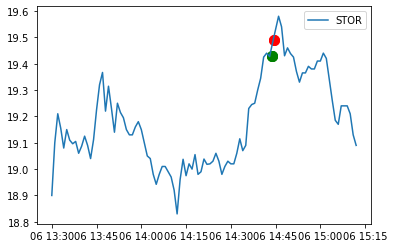

AXTI analysis for run 516 with profit 10.35


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-1890.60,-1890.60,buy,2020-05-06 13:50:06.898367,5.48,"[5.11, 5.17, 5.19, 5.29, 5.41, 5.45, 5.47]","[5.48, 5.48, 5.53, 5.53, 5.55, 5.55]",345,"{'avg': 5.2278, 'rsi': 73.19884925123812, 'macd': [0.04973693751925534, 0.05525740396515211, 0.05815512093598141, 0.06135811718451212, 0.06484356305234051], 'vwap': 5.491, 'supports': [5.11, 5.17, 5.29, 5.41, 5.45], 'sell_macd': [0.032761414267415745, 0.036085244578729636, 0.03768712216444481, 0.039484856358970255, 0.041463806947445114], 'slow macd': [-0.008431666564796991, -0.00534838684918526, -0.0026630529135527325, 0.00013167143572534457, 0.0030385622961599523], 'macd_signal': [0.026815861455719466, 0.032504169957605994, 0.037634360153281074, 0.04237911155952728, 0.04687200185808993], 'resistances': [5.53, 5.53], 'sell_macd_signal': [0.018570210263953467, 0.0220732171269087, 0.025195998134415924, 0.02805376977932679, 0.030735777212950455]}",6.31,5.22
1,10.35,1900.95,sell,2020-05-06 14:38:30.806681,5.51,None,None,345,"{'avg': 5.2922, 'rsi': [59.478391835000465, 63.33883341256594], 'vwap': 5.54, 'reasons': 'bail', 'movement': 0.010948905109488979, 'sell_macd': [0.030976103416606726, 0.029411680790467187, 0.027550940032560867, 0.02541074022078238, 0.02478447101393222], 'sell_macd_signal': [0.02288504814768338, 0.02419037467624014, 0.024862487747504287, 0.024972138242159905, 0.024934604796514367]}",6.31,5.22


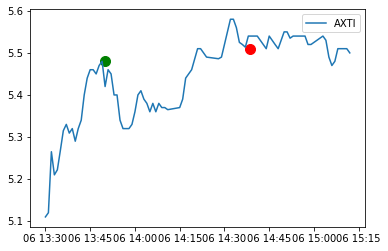

RUBI analysis for run 516 with profit -55.42


,profit,trade,operation,at,price,support,resistance,qty,indicators,target price,stop price
0,-2226.58,-2226.58,buy,2020-05-06 13:49:50.321051,6.83,"[6.45, 6.48, 6.5, 6.51, 6.55, 6.5501, 6.595]","[7.21, 7.21, 7.22, 7.24, 7.25]",326,"{'avg': 6.6804, 'rsi': 77.89076911251826, 'macd': [0.05833893449966965, 0.06164903144372236, 0.06752846316406202, 0.06976985880633357, 0.07152856070490721], 'vwap': 6.8304, 'supports': [6.45, 6.48, 6.51, 6.545, 6.595], 'sell_macd': [0.036256380080258666, 0.03820714615006171, 0.04182842950120591, 0.04306802133974408, 0.0439940926251019], 'slow macd': [0.020599330160052887, 0.022865380125776547, 0.025713328726586937, 0.02797253561005686, 0.03016627607244171], 'macd_signal': [0.04943438593963937, 0.051877315040455965, 0.055007544665177176, 0.057960007493408454, 0.0606737181357082], 'resistances': [7.21], 'sell_macd_signal': [0.031239880498476154, 0.03263333362879327, 0.0344723528032758, 0.03619148651056946, 0.037752007733475944]}",7.71,6.55
1,-55.42,2171.16,sell,2020-05-06 14:04:09.809509,6.66,None,None,326,"{'avg': 6.7057, 'rsi': [40.62038352642204, 39.69157310910164], 'vwap': 6.6616, 'reasons': 'below cost & macd negative & RSI trending down', 'movement': -0.02437774524158127, 'sell_macd': [0.010870211990286371, 0.009938014772265191, 0.007524120644296417, 0.002948045731018034, -0.0009936755745361125], 'sell_macd_signal': [0.02030932421262272, 0.018235062324551216, 0.016092873988500254, 0.01346390833700381, 0.010572391554695826]}",7.71,6.55


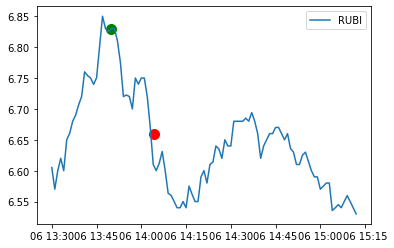

In [16]:
for run_id, count in runs.items():
    for symbol in minute_history:    
        if symbol not in trade_details[run_id]:
            continue
        start_date = datetime.strptime(start_day_to_analyze, "%Y-%m-%d") + timedelta(hours=9, minutes=30)
        minute_history_index = minute_history[symbol]["close"].index.get_loc(start_date, method='nearest')
        plt.plot(minute_history[symbol]["close"][minute_history_index:], label=symbol)

        delta = 0
        profit = 0
        
        operations = []
        deltas = []
        profits = []
        times = []
        prices = []
        qtys = []
        indicators = []
        target_price = []
        stop_price = []
        resistances = []
        supports = []
        for trade in trade_details[run_id][symbol]:
            resistance = None
            support = None
            if trade[0] == 'buy':
                resistance = find_resistance(trade[2], minute_history[symbol], trade[1])
                support = find_support(trade[2], minute_history[symbol], trade[1])
                
            delta = trade[2] * trade[3] * (1 if trade[0] == 'sell' or trade[0] == 'buy_short' else -1)
            profit += delta
            plt.scatter(pd.to_datetime(trade[1]), trade[2], c='g' if trade[0] == 'buy' or trade[0] == 'sell_short' else 'r', s=100)
            deltas.append(round(delta, 2))
            profits.append(round(profit, 2))
            operations.append(trade[0])
            times.append(pd.to_datetime(trade[1]))
            prices.append(trade[2])
            qtys.append(trade[3])
            indicators.append(trade[4])
            target_price.append(trade[6])
            stop_price.append(trade[5])    
            resistances.append(resistance)
            supports.append(support)
        d = {
            'profit': profits,
            'trade': deltas,
            'operation': operations,
            'at': times,
            'price': prices,
            'support': supports,
            'resistance': resistances,
            'qty': qtys,
            'indicators': indicators,
            'target price': target_price,
            'stop price': stop_price
        }   
        print (f'{symbol} analysis for run {run_id} with profit {round(profit, 2)}')
        display(HTML(pd.DataFrame(data=d).to_html()))
        plt.legend()
        plt.show()

In [ ]:
 pd.Timestamp('2020-04-16 13:44:06.066') 

In [ ]:
index = minute_history['NURO'].index.get_loc(pd.Timestamp('2020-04-16 13:44:06.066') , method='nearest')

In [ ]:
minute_history['NURO'][:index]

In [ ]:
series = minute_history['NURO'][:2417]['close']

In [ ]:
MACD(series.dropna().between_time("9:30", "16:00"))